#Creating Dataset


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Define the path to the ZIP file and the extraction directory
zip_file_path = '/content/drive/MyDrive/ROCtraining.zip'
extract_dir = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Training data unzipped!")

Training data unzipped!


## Sample Images

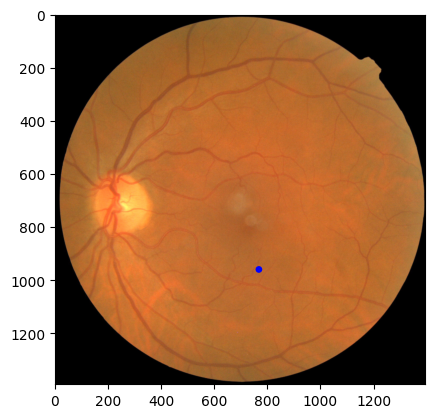

In [12]:
# looking at a sample image to understand image annotations
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import matplotlib.patches as patches

# from annotations
'''
<mark x="768" y="959">
<radius>10</radius>
</mark>
<lesion>microaneurysm</lesion>
<probability>1.0</probability>
'''

img_path = '/content/ROCtraining/image16_training.jpg'
img = Image.open(img_path)
plt.imshow(img)

x_center, y_center = 768, 959
radius = 10
circle = patches.Circle((x_center, y_center), radius, edgecolor='blue', facecolor='blue')
plt.gca().add_patch(circle)
plt.show()

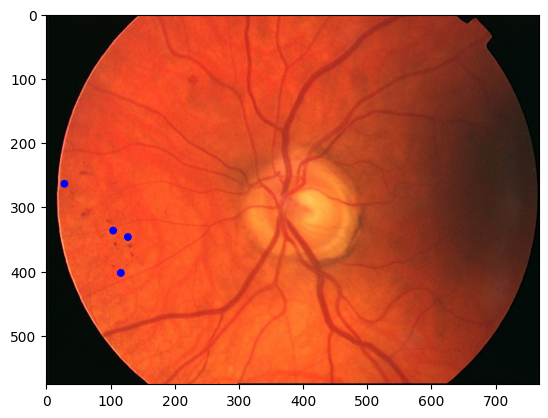

In [13]:
# from annotations, multiple lesions

img_path = '/content/ROCtraining/image29_training.jpg'
img = Image.open(img_path)
plt.imshow(img)

sample_annotations = [[116, 402, 5], [127, 346, 5], [104, 336, 5], [28, 263, 5]]

for samp in sample_annotations:
  x_center, y_center, radius = samp[0], samp[1], samp[2]
  radius = 5
  circle = patches.Circle((x_center, y_center), radius, edgecolor='blue', facecolor='blue')
  plt.gca().add_patch(circle)

plt.show()

## Parsing XML

In [6]:
from bs4 import BeautifulSoup

with open('/content/ROCtraining/annotations-consensus-ma-only.xml', 'r') as f:
	data = f.read()

bs_data = BeautifulSoup(data, "xml")
annotations = [];

for i in range(50):
  annotations.append([])
  img_name = "image" + str(i) + "_training.jpg"
  img_data = bs_data.find('annotations-per-image', {'imagename':img_name})
  marks = img_data.find_all('mark')
  for mark in marks:
    x, y = mark.get('x'), mark.get('y')
    radius = mark.find('radius').text
    annotations[-1].append((x,y, radius))

## Resizing Images & Creating Binary Masks

In [10]:
import cv2
import numpy as np

resized_annotations = []

# creating masked images
for i in range(50):
  resized_annotations.append([])
  img_path = '/content/ROCtraining/image' + str(i) + '_training.jpg'
  img_array = cv2.imread(img_path)
  old_h, old_w, _ = img_array.shape

  h, w = 576, 576

  resized_img = cv2.resize(img_array, (w, h), interpolation=cv2.INTER_AREA)
  img_array = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_array)

  mask = np.zeros(img_array.shape)

  for mark in annotations[i]:

    x, y, radius = mark
    x = int(x) * (w/old_w)
    y = int(y) * (h/old_h)
    radius_x = int(radius) * (w/old_w)
    radius_y = int(radius) * (h/old_h)

    resized_annotations[-1].append((int(x), int(y), int(radius_x), int(radius_y)))

    oval = patches.Ellipse((x, y), radius_x * 2, radius_y * 2, edgecolor='blue', facecolor='blue')
    for a in range(int(x - radius_x) - 1, int(x + radius_x) + 2):
      for b in range(int(y - radius_y)-1, int(y + radius_y) + 2):
        if oval.contains_point((a, b)):
          mask[b, a] = [255, 255, 255]

  plt.axis('off')
  if (i < 40):
    plt.savefig('/content/drive/MyDrive/CS269_TrainingData/train/data/img' + str(i) + '.png', bbox_inches='tight', pad_inches=0)
  else:
    plt.savefig('/content/drive/MyDrive/CS269_TrainingData/val/data/img' + str(i) + '.png', bbox_inches='tight', pad_inches=0)
  plt.clf()

  plt.imshow(mask)
  plt.axis('off')
  if (i < 40):
    plt.savefig('/content/drive/MyDrive/CS269_TrainingData/train/mask/img' + str(i) + '.png', bbox_inches='tight', pad_inches=0)
  else:
    plt.savefig('/content/drive/MyDrive/CS269_TrainingData/val/mask/img' + str(i) + '.png', bbox_inches='tight', pad_inches=0)
  plt.clf()

<Figure size 640x480 with 0 Axes>